#Gaussian Naive Bayes

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [14]:
df = pd.read_csv("Customer_Behaviour.csv")
df.tail()

,User ID,Gender,Age,EstimatedSalary,Purchased
395,15691863,Female,46,41000,1
396,15706071,Male,51,23000,1
397,15654296,Female,50,20000,1
398,15755018,Male,36,33000,0
399,15594041,Female,49,36000,1


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   User ID          400 non-null    int64 
 1   Gender           400 non-null    object
 2   Age              400 non-null    int64 
 3   EstimatedSalary  400 non-null    int64 
 4   Purchased        400 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 15.8+ KB


## Data Analysis

In [5]:
# Get categorical columns and numerical columns
categorical_cols = [feature for feature in df.columns if df[feature].dtype == "O"]
numerical_cols = [feature for feature in df.columns if df[feature].dtype != "O"]

In [7]:
# Check Missing values
df[categorical_cols].isnull().sum()

Gender    0
dtype: int64

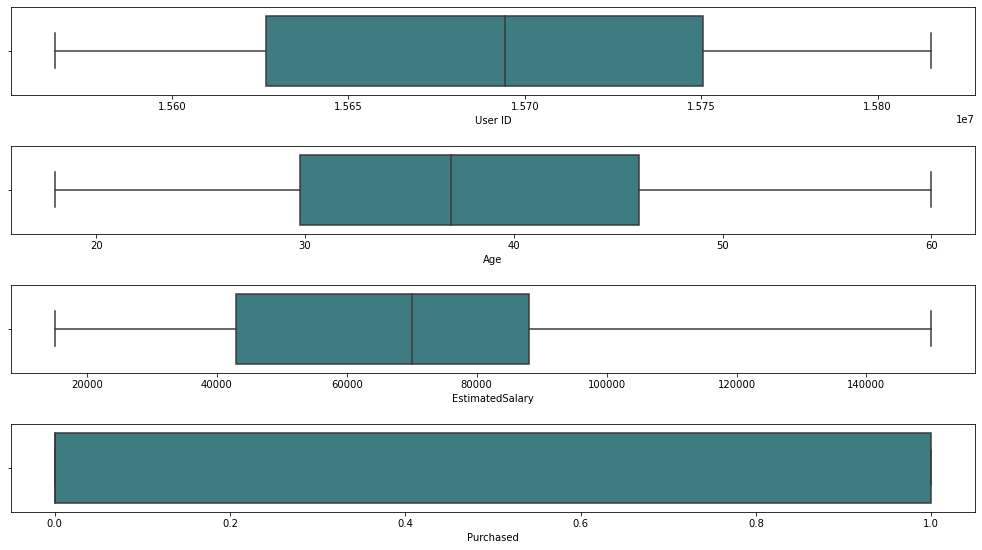

In [12]:
fig, axes=plt.subplots(len(numerical_cols), 1, figsize=(14, 2*len(numerical_cols)),sharex=False,sharey=False)

for i, column in enumerate(numerical_cols):
    sns.boxplot(x=column,data=df,palette='crest',ax=axes[i])
plt.tight_layout(pad=2.0)

<AxesSubplot:xlabel='Purchased', ylabel='Count'>

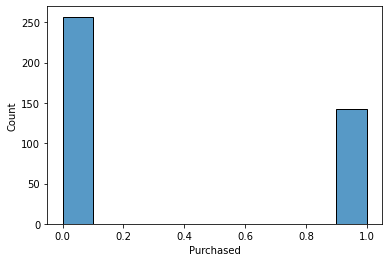

In [13]:
#Xem phân phối của EstimatedSalary
sns.histplot(x="Purchased", data=df)

<AxesSubplot:>

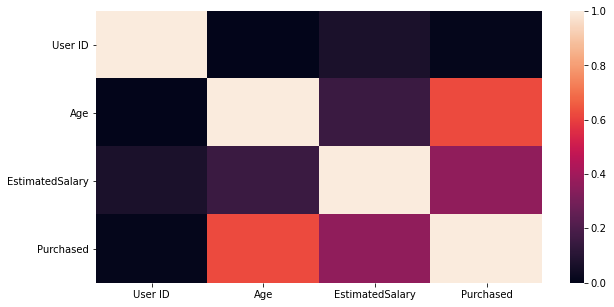

In [15]:
plt.figure(figsize=(10, 5))
sns.heatmap(df.corr())

## Preprocessing

In [16]:
def preprocessing_data(df):
    """
    Preprocess your data (eg. Drop null datapoints or fill missing data)
    :param df: pandas DataFrame
    :return: pandas DataFrame
    """
    df.drop("User ID", axis=1, inplace=True)
    return df

In [17]:
df = preprocessing_data(df)
df.head()

,Gender,Age,EstimatedSalary,Purchased
0,Male,19,19000,0
1,Male,35,20000,0
2,Female,26,43000,0
3,Female,27,57000,0
4,Male,19,76000,0


## Feature Engineering

<AxesSubplot:>

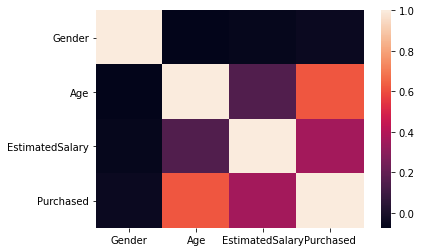

In [18]:
# Heatmap
import seaborn as sns

def apply_feature_engineering(df):
    """
    Apply all feature engineering to transform your data into number
    :param df: pandas DataFrame
    :return: pandas DataFrame
    """
    df["Gender"] = df["Gender"].astype("category").cat.codes
    return df

df = apply_feature_engineering(df)
sns.heatmap(df.corr()) # Show heatmap after normalized data

##Model Training

In [19]:
def prepare_X_y(df):
    """
    Feature engineering and create X and y
    :param df: pandas dataframe
    :return: (X, y) output feature matrix (dataframe), target (series)
    """
    feature_names = df.columns.tolist()
    feature_names.remove("Purchased")

    X = df[feature_names].values
    y = df.Purchased.values
    return X, y

X, y = prepare_X_y(df)

In [20]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

In [21]:
# --- Without Scaler
from sklearn.naive_bayes import GaussianNB

# Model training
naive_model = GaussianNB()
naive_model.fit(X_train, y_train.ravel())

from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
predicted_label = naive_model.predict(X_test)
print(classification_report(y_test, predicted_label))


              precision    recall  f1-score   support

           0       0.86      0.86      0.86        72
           1       0.79      0.79      0.79        48

    accuracy                           0.83       120
   macro avg       0.83      0.83      0.83       120
weighted avg       0.83      0.83      0.83       120



In [23]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.naive_bayes import GaussianNB

# Scaler
normalizer = MinMaxScaler()
X_normal_train = normalizer.fit_transform(X_train)
X_normal_test = normalizer.transform(X_test)

# Model training
naive_model = GaussianNB()
naive_model.fit(X_normal_train, y_train.ravel())

from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
predicted_label = naive_model.predict(X_normal_test)
print(classification_report(y_test, predicted_label))


              precision    recall  f1-score   support

           0       0.87      0.86      0.87        72
           1       0.80      0.81      0.80        48

    accuracy                           0.84       120
   macro avg       0.83      0.84      0.84       120
weighted avg       0.84      0.84      0.84       120



In [24]:
# -- Build a full pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

# Define a Standard Scaler to normalize inputs
scaler = MinMaxScaler()

# set the tolerance to a large value to make the example faster
gau_nb = GaussianNB()
pipe = Pipeline(steps=[("scaler", scaler), ("gau_nb", gau_nb)]) #Build a pipeline with a scaler and a model

# Parameters of pipelines can be set using '__' separated parameter names:
var_smoothing_values = np.logspace(-4, -9, num=100)
param_grid = {
    "scaler__feature_range": [(-1, 1), (0, 1)],
    'gau_nb__var_smoothing': var_smoothing_values
    }

search = GridSearchCV(pipe, param_grid, n_jobs=2)
search.fit(X_train, y_train)
print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)



from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
predicted_label = search.predict(X_test)
print(classification_report(y_test, predicted_label))

Best parameter (CV score=0.896):
{'gau_nb__var_smoothing': 0.0001, 'scaler__feature_range': (-1, 1)}
              precision    recall  f1-score   support

           0       0.87      0.86      0.87        72
           1       0.80      0.81      0.80        48

    accuracy                           0.84       120
   macro avg       0.83      0.84      0.84       120
weighted avg       0.84      0.84      0.84       120



In [25]:
def build_model(X, y):
    # Define a Standard Scaler to normalize inputs
    scaler = MinMaxScaler()

    # set the tolerance to a large value to make the example faster
    gau_nb = GaussianNB()
    pipe = Pipeline(steps=[("scaler", scaler), ("gau_nb", gau_nb)]) #Build a pipeline with a scaler and a model

    # Parameters of pipelines can be set using '__' separated parameter names:
    var_smoothing_values = np.logspace(-4, -9, num=100)
    param_grid = {
        "scaler__feature_range": [(-1, 1), (0, 1)],
        'gau_nb__var_smoothing': var_smoothing_values
        }

    search = GridSearchCV(pipe, param_grid, n_jobs=2)
    search.fit(X, y)

    return search

naive_model = build_model(X, y) # Why?

#Categorical Naive Bayes

In [26]:
df = pd.read_csv("Covid Dataset.csv")
display(df.head())
len(df.columns)

,Breathing Problem,Fever,Dry Cough,Sore throat,Running Nose,Asthma,Chronic Lung Disease,Headache,Heart Disease,Diabetes,...,Fatigue,Gastrointestinal,Abroad travel,Contact with COVID Patient,Attended Large Gathering,Visited Public Exposed Places,Family working in Public Exposed Places,Wearing Masks,Sanitization from Market,COVID-19
0,Yes,Yes,Yes,Yes,Yes,No,No,No,No,Yes,...,Yes,Yes,No,Yes,No,Yes,Yes,No,No,Yes
1,Yes,Yes,Yes,Yes,No,Yes,Yes,Yes,No,No,...,Yes,No,No,No,Yes,Yes,No,No,No,Yes
2,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,No,Yes,...,Yes,Yes,Yes,No,No,No,No,No,No,Yes
3,Yes,Yes,Yes,No,No,Yes,No,No,Yes,Yes,...,No,No,Yes,No,Yes,Yes,No,No,No,Yes
4,Yes,Yes,Yes,Yes,Yes,No,Yes,Yes,Yes,Yes,...,No,Yes,No,Yes,No,Yes,No,No,No,Yes


21

Đây là dataset để giải quyết việc phân biệt cảm cúm và Covid19, bao gồm:
- 'Breathing Problem': yes or no
- 'Fever': yes or no
- 'Dry Cough': yes or no
- 'Sore throat': yes or no
- 'Running Nose': yes or no
- 'Asthma': yes or no 
- 'Chronic Lung Disease': yes or no
- 'Headache': yes or no
- 'Heart Disease': yes or no 
- 'Diabetes': yes or no
- 'Hyper Tension': yes or no
- 'Fatigue ': yes or no
- 'Gastrointestinal ': yes or no
- 'Abroad travel': yes or no
- 'Contact with COVID Patient': yes or no
- 'Attended Large Gathering': yes or no
- 'Visited Public Exposed Places': yes or no
- 'Family working in Public Exposed Places': yes or no
- 'Wearing Masks': yes or no
- 'Sanitization from Market': yes or no
- 'COVID-19': yes or no (Label)




In [27]:
cat_cols = [col for col in df.columns if df[col].dtypes == "O"] # Lấy các features có dạng categorical (string) 
cat_cols.remove("COVID-19")
X = pd.get_dummies(df, columns=cat_cols)
X = X.drop(["COVID-19"], axis=1)
y = df[df.columns[-1]].values
y = [0 if i=="Yes" else 1 for i in y] 

In [28]:
#Chia dataset
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=0)

In [29]:
#Dùng model CategoricalNB
from sklearn.naive_bayes import CategoricalNB
model = CategoricalNB()
"""
ở CategoricalNB ta cần lưu ý alpha
alpha sẽ nhận vào 1 số thực dương với mục đích là cộng cho cả tử và mẫu xác suất hậu nghiệm P(x|c) (Xác xuất feature x khi biết label c ) 
mục đích của việc này giúp cho P(x|c) tránh bị bằng 0 
"""
model.fit(X_train, y_train)

#Chạy các metrics
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report

predicted_label = model.predict(X_test)
print(classification_report(y_test, predicted_label))


              precision    recall  f1-score   support

           0       0.98      0.97      0.97      1313
           1       0.87      0.91      0.89       318

    accuracy                           0.95      1631
   macro avg       0.92      0.94      0.93      1631
weighted avg       0.96      0.95      0.95      1631



In [30]:
#Dùng model CategoricalNB
from sklearn.naive_bayes import BernoulliNB
model = BernoulliNB()
"""
ở CategoricalNB ta cần lưu ý alpha
alpha sẽ nhận vào 1 số thực dương với mục đích là cộng cho cả tử và mẫu xác suất hậu nghiệm P(x|c) (Xác xuất feature x khi biết label c ) 
mục đích của việc này giúp cho P(x|c) tránh bị bằng 0 
"""
model.fit(X_train, y_train)

#Chạy các metrics
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report

predicted_label = model.predict(X_test)
print(classification_report(y_test, predicted_label))


              precision    recall  f1-score   support

           0       0.98      0.97      0.97      1313
           1       0.87      0.91      0.89       318

    accuracy                           0.95      1631
   macro avg       0.92      0.94      0.93      1631
weighted avg       0.96      0.95      0.95      1631



In [31]:
#Dùng model CategoricalNB
from sklearn.naive_bayes import GaussianNB
model = GaussianNB()
"""
ở CategoricalNB ta cần lưu ý alpha
alpha sẽ nhận vào 1 số thực dương với mục đích là cộng cho cả tử và mẫu xác suất hậu nghiệm P(x|c) (Xác xuất feature x khi biết label c ) 
mục đích của việc này giúp cho P(x|c) tránh bị bằng 0 
"""
model.fit(X_train, y_train)

#Chạy các metrics
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report

predicted_label = model.predict(X_test)
print(precision_score(y_test, predicted_label))
print(recall_score(y_test, predicted_label))
print(f1_score(y_test, predicted_label))
print(classification_report(y_test, predicted_label))


0.43983402489626555
1.0
0.6109510086455331
              precision    recall  f1-score   support

           0       1.00      0.69      0.82      1313
           1       0.44      1.00      0.61       318

    accuracy                           0.75      1631
   macro avg       0.72      0.85      0.71      1631
weighted avg       0.89      0.75      0.78      1631



In [32]:
# -- Build a full pipeline
from sklearn.decomposition import PCA
from sklearn.naive_bayes import BernoulliNB
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

pca = PCA()
nb = BernoulliNB()
pipe = Pipeline(steps=[("pca", pca), ("nb", nb)]) #Build a pipeline with a scaler and a model

# Parameters of pipelines can be set using '__' separated parameter names:
alpha = np.logspace(-1, -9, num=100)
param_grid = {
    "pca__n_components": [5, 15, 30, 35],
    'nb__alpha': alpha
    }

search = GridSearchCV(pipe, param_grid, scoring="recall", n_jobs=2)
search.fit(X_train, y_train)
print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)

from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
predicted_label = search.predict(X_test)
print(classification_report(y_test, predicted_label))

Best parameter (CV score=0.697):
{'nb__alpha': 0.1, 'pca__n_components': 35}
              precision    recall  f1-score   support

           0       0.93      0.86      0.89      1313
           1       0.56      0.75      0.64       318

    accuracy                           0.84      1631
   macro avg       0.75      0.80      0.77      1631
weighted avg       0.86      0.84      0.85      1631



In [33]:
# -- Build a full pipeline
from sklearn.decomposition import PCA
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

pca = PCA()
gau_nb = GaussianNB()
pipe = Pipeline(steps=[("pca", pca), ("gau_nb", gau_nb)]) #Build a pipeline with a scaler and a model

# Parameters of pipelines can be set using '__' separated parameter names:
var_smoothing_values = np.logspace(-4, -9, num=100)
param_grid = {
    "pca__n_components": [5, 15, 30, 35],
    'gau_nb__var_smoothing': var_smoothing_values
    }

search = GridSearchCV(pipe, param_grid, scoring="recall", n_jobs=2)
search.fit(X_train, y_train)
print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)

from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
predicted_label = search.predict(X_test)
print(classification_report(y_test, predicted_label))

Best parameter (CV score=0.880):
{'gau_nb__var_smoothing': 0.0001, 'pca__n_components': 30}
              precision    recall  f1-score   support

           0       0.97      0.98      0.98      1313
           1       0.92      0.89      0.90       318

    accuracy                           0.96      1631
   macro avg       0.95      0.93      0.94      1631
weighted avg       0.96      0.96      0.96      1631



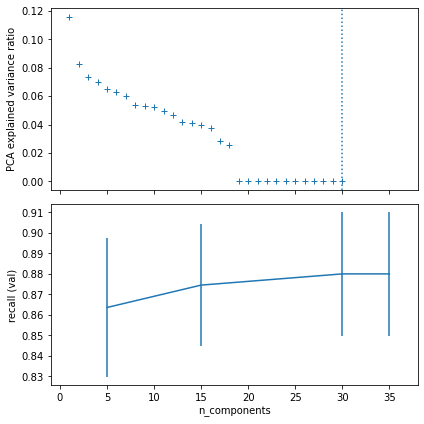

In [34]:
fig, (ax0, ax1) = plt.subplots(nrows=2, sharex=True, figsize=(6, 6))
ax0.plot(
    np.arange(1, search.best_estimator_.named_steps["pca"].n_components_ + 1), search.best_estimator_.named_steps["pca"].explained_variance_ratio_, "+", linewidth=2
)
ax0.set_ylabel("PCA explained variance ratio")

ax0.axvline(
    search.best_estimator_.named_steps["pca"].n_components_,
    linestyle=":",
    label="n_components chosen",
)
# For each number of components, find the best classifier results
results = pd.DataFrame(search.cv_results_)
components_col = "param_pca__n_components"
best_clfs = results.groupby(components_col).apply(
    lambda g: g.nlargest(1, "mean_test_score")
)

best_clfs.plot(
    x=components_col, y="mean_test_score", yerr="std_test_score", legend=False, ax=ax1
)
ax1.set_ylabel("recall (val)")
ax1.set_xlabel("n_components")

plt.xlim(-1, 38)

plt.tight_layout()
plt.show()

#Introduce mixed naive bayes

#Example
https://pypi.org/project/mixed-naive-bayes/

In [ ]:
#Chạy dòng code này để tải thư viện 
!pip install git+https://github.com/remykarem/mixed-naive-bayes#egg=mixed_naive_bayes

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/remykarem/mixed-naive-bayes to /tmp/pip-install-ipqpj9r_/mixed-naive-bayes_528ba8c906704ec0ac47d212f6c9b422
  Running command git clone --filter=blob:none --quiet https://github.com/remykarem/mixed-naive-bayes /tmp/pip-install-ipqpj9r_/mixed-naive-bayes_528ba8c906704ec0ac47d212f6c9b422
  Resolved https://github.com/remykarem/mixed-naive-bayes to commit 6d90de8adf75dbef032ad51029ad3782190ec577
  Preparing metadata (setup.py) ... done
  Created wheel for mixed_naive_bayes: filename=mixed_naive_bayes-0.0.4-py3-none-any.whl size=10881 sha256=62233b4bf444f70bc4e7d845a5b6a4b512f9678aad689a9a3c518cdf65875649
  Stored in directory: /tmp/pip-ephem-wheel-cache-182rvgyf/wheels/16/0d/9f/929c7af51d4b12da89d0ac3c6ce4f4981214fee69d9440028e
Successfully built mixed_naive_bayes


In [35]:
from mixed_naive_bayes import MixedNB
X = [[0, 0, 180, 75],
     [1, 1, 165, 61],
     [2, 1, 166, 60],
     [1, 1, 173, 68],
     [0, 2, 178, 71]]
y = [0, 0, 1, 1, 0]
clf = MixedNB(categorical_features=[0,1]) #categorical columns are at 0 & 1
clf.fit(X,y)
clf.predict(X)

"""
Ta có thể thấy cách dùng rất giống sklearn, tuy nhiên ta phải khai báo categorical_features với những categorical features theo thứ tự vị trí
"""

'\nTa có thể thấy cách dùng rất giống sklearn, tuy nhiên ta phải khai báo categorical_features với những categorical features theo thứ tự vị trí\n'